In [1]:
import zipfile
with zipfile.ZipFile("CPS_data_even_years.zip","r") as zip_ref:
    zip_ref.extractall("CPS_data_even_years")

In [2]:
#PRE-PROCESSING 
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk",font_scale=2)

In [3]:
np.random.seed(4)

In [4]:
CPS_data_frame = pd.read_stata("CPS_data_even_years/CPS_data.dta",
                               convert_categoricals=False, 
                               convert_missing=False)

In [5]:
CPS_data_frame = CPS_data_frame[(10000 < \
                                 CPS_data_frame['inctot']) & (CPS_data_frame['inctot'] < \
                                                              500000)] 

In [6]:
CPS_data_frame = CPS_data_frame[CPS_data_frame['age'] >= 30] 

In [7]:
CPS_data_frame['worker'] = (CPS_data_frame['labforce'] == 2).astype(int)
CPS_data_frame['female'] = (CPS_data_frame['sex'] == 2).astype(int)

In [8]:
CPS_data_frame['college'] = (CPS_data_frame['educ99'] >= 15).astype(int)

In [9]:
CPS_data_frame['masters'] = (CPS_data_frame['educ99'] == 16).astype(int)

In [10]:
CPS_data_frame['high_school'] = (CPS_data_frame['educ99'] >= 10).astype(int)

In [11]:
CPS_data_frame['professional_degree'] = (CPS_data_frame['educ99'] == 17).astype(int)

In [12]:
CPS_data_frame['doctorate'] = (CPS_data_frame['educ99'] == 18).astype(int)

In [13]:
CPS_data_frame['white'] = (CPS_data_frame['race'] == 100).astype(int)

In [14]:
CPS_data_frame['not_hispanic'] = (CPS_data_frame['hispan'] == 0).astype(int)

In [15]:
cutoff = 40000
bins = [0, cutoff, 500000]
group_names = [0, 1]
CPS_data_frame["high_income"] = pd.cut(CPS_data_frame['inctot'], bins, labels=group_names).astype(int)

In [16]:
pd.value_counts(CPS_data_frame["high_income"])

0    147851
1    125640
Name: high_income, dtype: int64

In [17]:
list_of_features = ['high_income', 'age', 'female', 'worker', 'white', 'not_hispanic',
                    'college', 'masters', 'high_school', 'professional_degree', 'doctorate']

In [18]:
temp_df = CPS_data_frame[list_of_features]

In [19]:
temp_df = temp_df[temp_df['age'] <= 39]

In [20]:
temp_df = temp_df.dropna()

In [21]:
pd.value_counts(temp_df["high_income"])

0    33423
1    31016
Name: high_income, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(
    temp_df.drop('high_income', 1), temp_df['high_income'], test_size=0.2, random_state = 47)

In [45]:
X.columns.tolist()

['age',
 'female',
 'worker',
 'white',
 'not_hispanic',
 'college',
 'masters',
 'high_school',
 'professional_degree',
 'doctorate']

In [24]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [25]:
kfold = KFold(n_splits=4, shuffle=True, random_state=4)

In [26]:
class_tree_1 = tree.DecisionTreeClassifier(criterion ='entropy', 
                                           max_depth=7, 
                                           min_samples_split=25,
                                           min_samples_leaf=10)

class_tree_2 = tree.DecisionTreeClassifier(criterion ='gini', 
                                           max_depth=9, 
                                           min_samples_split=40,
                                           min_samples_leaf=15)

class_tree_3 = tree.DecisionTreeClassifier(criterion ='entropy', 
                                           max_depth=11, 
                                           min_samples_split=50,
                                           min_samples_leaf=15)

class_tree_4 = tree.DecisionTreeClassifier(criterion ='gini', 
                                           max_depth=11, 
                                           min_samples_split=100,
                                           min_samples_leaf=30)



scores_for_class_tree_1 = cross_val_score(class_tree_1,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_class_tree_2 = cross_val_score(class_tree_2,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_class_tree_3 = cross_val_score(class_tree_3,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_class_tree_4 = cross_val_score(class_tree_4,
                                          X, y,
                                          cv=kfold, scoring='f1')

In [27]:
class_tree_1.fit(X, y)
class_tree_2.fit(X, y)
class_tree_3.fit(X, y)
class_tree_4.fit(X, y)

scores_for_class_tree_1 = np.append(scores_for_class_tree_1,
                                    f1_score(y_test, class_tree_1.predict(X_test)))
scores_for_class_tree_2 = np.append(scores_for_class_tree_2,
                                    f1_score(y_test, class_tree_2.predict(X_test)))
scores_for_class_tree_3 = np.append(scores_for_class_tree_3,
                                    f1_score(y_test, class_tree_3.predict(X_test)))
scores_for_class_tree_4 = np.append(scores_for_class_tree_4,
                                    f1_score(y_test, class_tree_4.predict(X_test)))

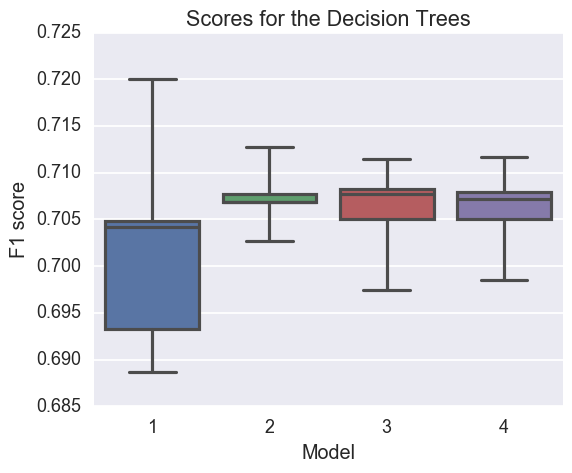

In [28]:
sns.set_context("talk",font_scale=1)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
sns.boxplot(data=[scores_for_class_tree_1,
                  scores_for_class_tree_2,
                  scores_for_class_tree_3,
                  scores_for_class_tree_4], whis=100)
fig.get_axes()[0].set_xlabel("Model")
fig.get_axes()[0].set_xticklabels(["1", "2", "3", "4"])
fig.get_axes()[0].set_ylabel("F1 score")
fig.get_axes()[0].set_title("Scores for the Decision Trees")
plt.savefig("Decision_Tree_Boxplots_small.pdf",bbox_inches='tight')
plt.tight_layout()
plt.show()

In [29]:
from sklearn.ensemble import AdaBoostClassifier

In [30]:
AdaBoost_1 = AdaBoostClassifier(n_estimators=50, 
                                base_estimator=tree.DecisionTreeClassifier(max_depth=3))

AdaBoost_2 = AdaBoostClassifier(n_estimators=50, 
                                base_estimator=tree.DecisionTreeClassifier(min_samples_leaf=200))
AdaBoost_3 = AdaBoostClassifier(n_estimators=50, 
                                base_estimator=tree.DecisionTreeClassifier(max_depth=3,
                                                                          min_samples_leaf=40))

AdaBoost_4 = AdaBoostClassifier(n_estimators=50, 
                                base_estimator=tree.DecisionTreeClassifier(max_depth=3, 
                                                                          min_samples_split=250))



scores_for_AdaBoost_1 = cross_val_score(AdaBoost_1,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_AdaBoost_2 = cross_val_score(AdaBoost_2,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_AdaBoost_3 = cross_val_score(AdaBoost_3,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_AdaBoost_4 = cross_val_score(AdaBoost_4,
                                          X, y,
                                          cv=kfold, scoring='f1')

In [31]:
AdaBoost_1.fit(X, y)
AdaBoost_2.fit(X, y)
AdaBoost_3.fit(X, y)
AdaBoost_4.fit(X, y)

scores_for_AdaBoost_1 = np.append(scores_for_AdaBoost_1,
                                    f1_score(y_test, AdaBoost_1.predict(X_test)))
scores_for_AdaBoost_2 = np.append(scores_for_AdaBoost_2,
                                    f1_score(y_test, AdaBoost_2.predict(X_test)))
scores_for_AdaBoost_3 = np.append(scores_for_AdaBoost_3,
                                    f1_score(y_test, AdaBoost_3.predict(X_test)))
scores_for_AdaBoost_4 = np.append(scores_for_AdaBoost_4,
                                    f1_score(y_test, AdaBoost_4.predict(X_test)))

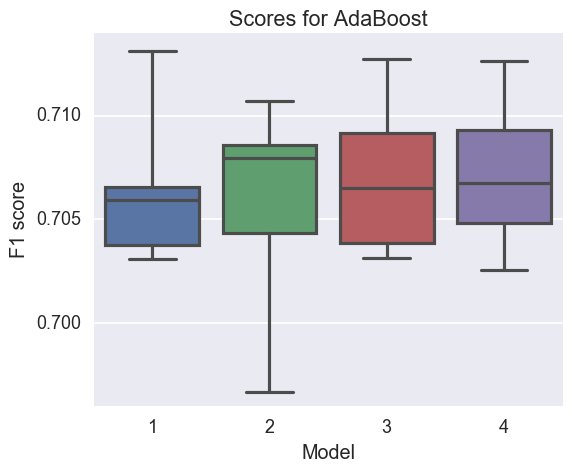

In [32]:
sns.set_context("talk",font_scale=1)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
sns.boxplot(data=[scores_for_AdaBoost_1,
                  scores_for_AdaBoost_2,
                  scores_for_AdaBoost_3,
                  scores_for_AdaBoost_4], whis=100)
fig.get_axes()[0].set_xlabel("Model")
fig.get_axes()[0].set_xticklabels(["1", "2", "3", "4"])
fig.get_axes()[0].set_ylabel("F1 score")
fig.get_axes()[0].set_title("Scores for AdaBoost")
plt.savefig("AdaBoost_Tree_Boxplots_small.pdf",bbox_inches='tight')
plt.tight_layout()
plt.show()

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
RandomForest_1 = RandomForestClassifier(n_estimators=25, 
                                        criterion='gini', 
                                        max_depth=9, random_state=4)

RandomForest_2 = RandomForestClassifier(n_estimators=55, 
                                        criterion='entropy', 
                                        max_depth=9, random_state=4)

RandomForest_3 = RandomForestClassifier(n_estimators=15, 
                                        criterion='gini', 
                                        max_depth=10, random_state=4)

RandomForest_4 = RandomForestClassifier(n_estimators=80, 
                                        criterion='entropy', 
                                        max_depth=11, random_state=4)


scores_for_RandomForest_1 = cross_val_score(RandomForest_1,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_RandomForest_2 = cross_val_score(RandomForest_2,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_RandomForest_3 = cross_val_score(RandomForest_3,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_RandomForest_4 = cross_val_score(RandomForest_4,
                                          X, y,
                                          cv=kfold, scoring='f1')

In [35]:
RandomForest_1.fit(X, y)
RandomForest_2.fit(X, y)
RandomForest_3.fit(X, y)
RandomForest_4.fit(X, y)

scores_for_RandomForest_1 = np.append(scores_for_RandomForest_1,
                                    f1_score(y_test, RandomForest_1.predict(X_test)))
scores_for_RandomForest_2 = np.append(scores_for_RandomForest_2,
                                    f1_score(y_test, RandomForest_2.predict(X_test)))
scores_for_RandomForest_3 = np.append(scores_for_RandomForest_3,
                                    f1_score(y_test, RandomForest_3.predict(X_test)))
scores_for_RandomForest_4 = np.append(scores_for_RandomForest_4,
                                    f1_score(y_test, RandomForest_4.predict(X_test)))

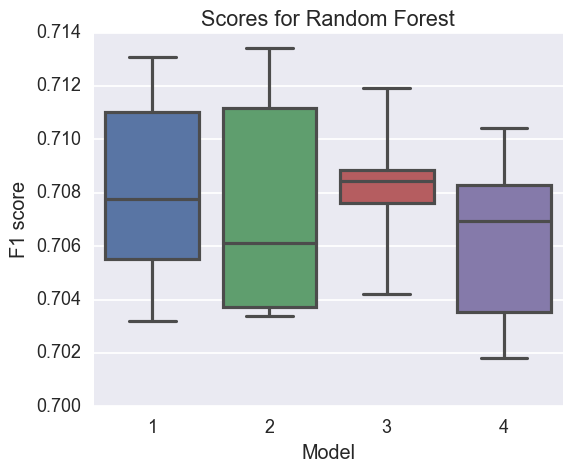

In [36]:
sns.set_context("talk",font_scale=1)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
sns.boxplot(data=[scores_for_RandomForest_1,
                  scores_for_RandomForest_2,
                  scores_for_RandomForest_3,
                  scores_for_RandomForest_4], whis=100)
fig.get_axes()[0].set_xlabel("Model")
fig.get_axes()[0].set_xticklabels(["1", "2", "3", "4"])
fig.get_axes()[0].set_ylabel("F1 score")
fig.get_axes()[0].set_title("Scores for Random Forest")
plt.savefig("Random_Forest_Tree_Boxplots_small.pdf",bbox_inches='tight')
plt.tight_layout()
plt.show()

In [37]:
from sklearn.neural_network import MLPClassifier

In [38]:
MLP_1 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=(5,), random_state=4)

MLP_2 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=(10,), random_state=4)

MLP_3 = MLPClassifier(solver='sgd', alpha=1e-5,
                      hidden_layer_sizes=(8,), random_state=4)

MLP_4 = MLPClassifier(solver='sgd', alpha=1e-5, learning_rate='constant',
                      hidden_layer_sizes=(7,), random_state=4)


scores_for_MLP_1 = cross_val_score(MLP_1,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_MLP_2 = cross_val_score(MLP_2,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_MLP_3 = cross_val_score(MLP_3,
                                          X, y,
                                          cv=kfold, scoring='f1')
scores_for_MLP_4 = cross_val_score(MLP_4,
                                          X, y,
                                          cv=kfold, scoring='f1')

In [39]:
MLP_1.fit(X, y)
MLP_2.fit(X, y)
MLP_3.fit(X, y)
MLP_4.fit(X, y)

scores_for_MLP_1 = np.append(scores_for_MLP_1,
                                    f1_score(y_test, MLP_1.predict(X_test)))
scores_for_MLP_2 = np.append(scores_for_MLP_2,
                                    f1_score(y_test, MLP_2.predict(X_test)))
scores_for_MLP_3 = np.append(scores_for_MLP_3,
                                    f1_score(y_test, MLP_3.predict(X_test)))
scores_for_MLP_4 = np.append(scores_for_MLP_4,
                                    f1_score(y_test, MLP_4.predict(X_test)))

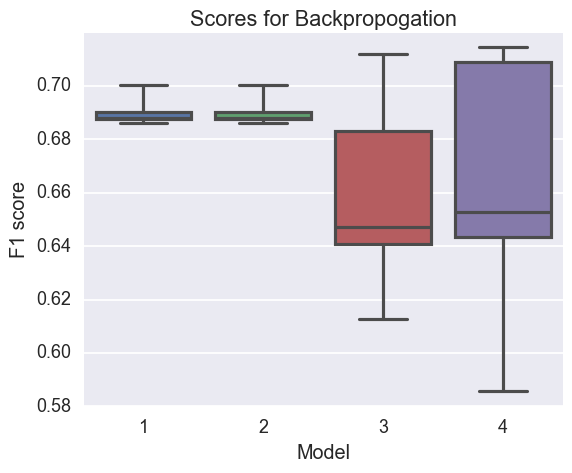

In [40]:
sns.set_context("talk",font_scale=1)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
sns.boxplot(data=[scores_for_MLP_1,
                  scores_for_MLP_1,
                  scores_for_MLP_3,
                  scores_for_MLP_4], whis=100)
fig.get_axes()[0].set_xlabel("Model")
fig.get_axes()[0].set_xticklabels(["1", "2", "3", "4"])
fig.get_axes()[0].set_ylabel("F1 score")
fig.get_axes()[0].set_title("Scores for Backpropogation")
plt.savefig("Backpropogation_Tree_Boxplots_small.pdf",bbox_inches='tight')
plt.tight_layout()
plt.show()

In [41]:
from sklearn.ensemble import VotingClassifier

In [42]:
AdaBoost_1 = AdaBoostClassifier(n_estimators=50, 
                                base_estimator=tree.DecisionTreeClassifier(max_depth=3))

RandomForest_1 = RandomForestClassifier(n_estimators=25, 
                                        criterion='gini', 
                                        max_depth=9, random_state=4)

extra_classifier = VotingClassifier(estimators=[('ab', AdaBoost_1),
                                                ('rf', RandomForest_1)],
                                    voting='hard')

scores_for_extra = cross_val_score(extra_classifier,
                                          X, y,
                                          cv=kfold, scoring='f1')


extra_classifier.fit(X, y)

scores_for_extra = np.append(scores_for_extra,
                                    f1_score(y_test, extra_classifier.predict(X_test)))

print(scores_for_extra)

[ 0.7056267   0.70257979  0.70583652  0.7025637   0.71281296]


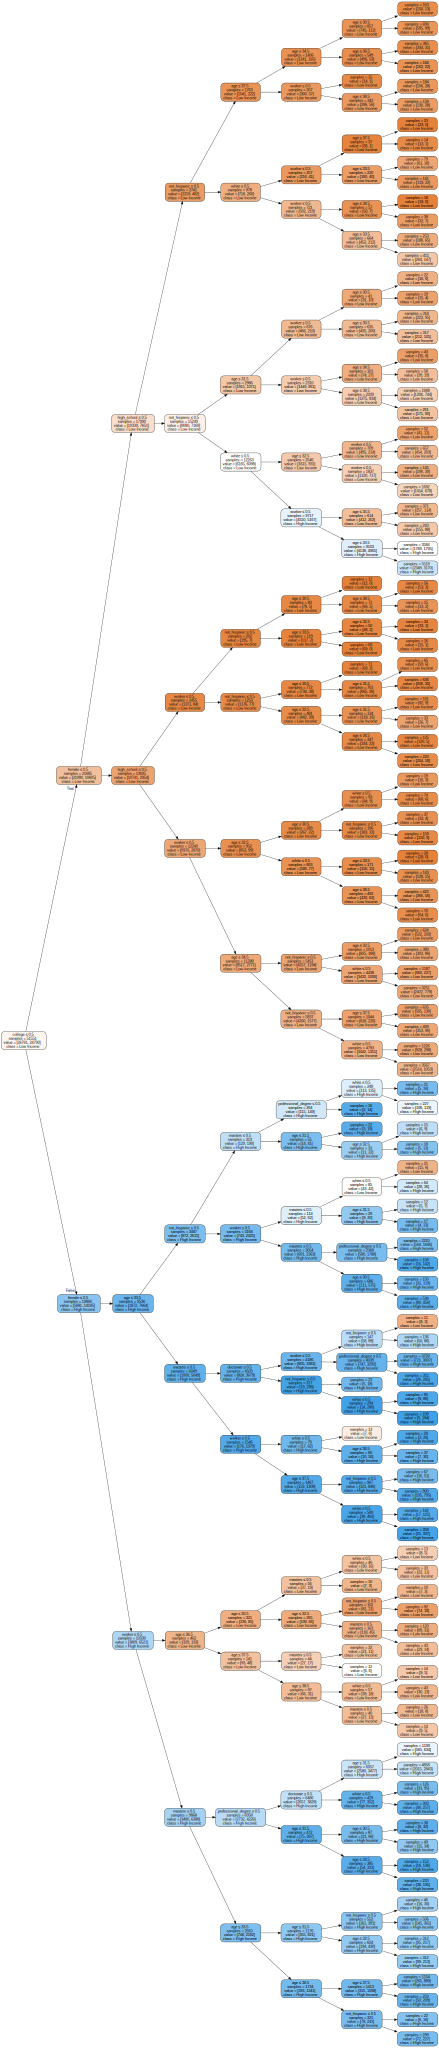

In [46]:
# THIS CELL IS OPTIONAL

from sklearn.tree import export_graphviz
import graphviz

export_graphviz(class_tree_1, out_file="mytree.dot", rotate=True, impurity=False,
                feature_names=X.columns.tolist(), proportion=False,
                class_names=['Low Income','High Income'], filled=True, rounded=True, special_characters=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)